In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import os
import time
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
bcw_train = pd.read_csv(os.path.join('/content/drive/MyDrive/Datasets/SI_final_project', 'bcw_train.csv'))
bcw_test = pd.read_csv(os.path.join('/content/drive/MyDrive/Datasets/SI_final_project', 'bcw_test.csv'))
model_metrics = pd.read_csv(os.path.join('/content/drive/MyDrive/Datasets/SI_final_project', 'model_metrics.csv'))

Mounted at /content/drive


In [2]:
def decision_boudary(model, min_vals, max_vals, num_features, feature_ids=[0,1]):
    """ Calcula las clasificaciones para una malla regular en dos de las dimensiones de
    entrada del modelo.

    - Argumentos:
      model :  modelo de ML previamente entrenado.
      min_vals : array o lista 2D con los valores mínimos de la malla regular.
      max_vals : array o lista 2D con los valores máximos de la malla regular.
      num_features : número de variables de entrada totales del modelo (aunque representemos solo 2
              el modelo puede tener muchas más).
      feature_ids : índices de las variables que vamos usar en la malla regular.
    """
    # Primero generamos una malla de puntos que cubra el espacio de búsqueda en el
    # cuadrado  definido por min_vals y max_vals.
    ranges = [np.arange(min_v-.1, max_v+.1, 0.05) for min_v, max_v in zip(min_vals, max_vals)]
    xx, yy = np.meshgrid(*ranges)

    # Solo nos interesan las 2 primeras variables, rellenamos con ceros el resto.
    X = np.zeros([xx.ravel().shape[0], num_features])
    X[:, feature_ids[0]] = xx.ravel()
    X[:, feature_ids[1]] = yy.ravel()

    # Evaluamos cada punto de la malla en el modelo árbol de decisión. De esta
    # manera, tenemos una aproximación razonable de la decisión que tomaría nuestro
    # modelo en cada punto del espacio de búsqueda.
    zz = model.predict(X).reshape(xx.shape)
    return xx, yy, zz

# Train

Parametros a optimizar interesantes:
- Learning rate. Amplitud de los saltos realizados por el gradiente al entrenar (en la dirección del minimo local). Si es muy grande podemos saltarnoslo y si es muy pequeño es computacionalmente demasiado agotador o podriamos perdernos alguna oportunidad de minimo supremo.
- Batch size. Numero de muestras usadas por backpropagation para estimar el gradiente.  
- Optimizer. Algoritmo de retropropagación: sgd, adam y lbfgs
- Numero de capas.
- Numero de neuronas.
- Alpha. Valor por el multiplicamos la regularización L2

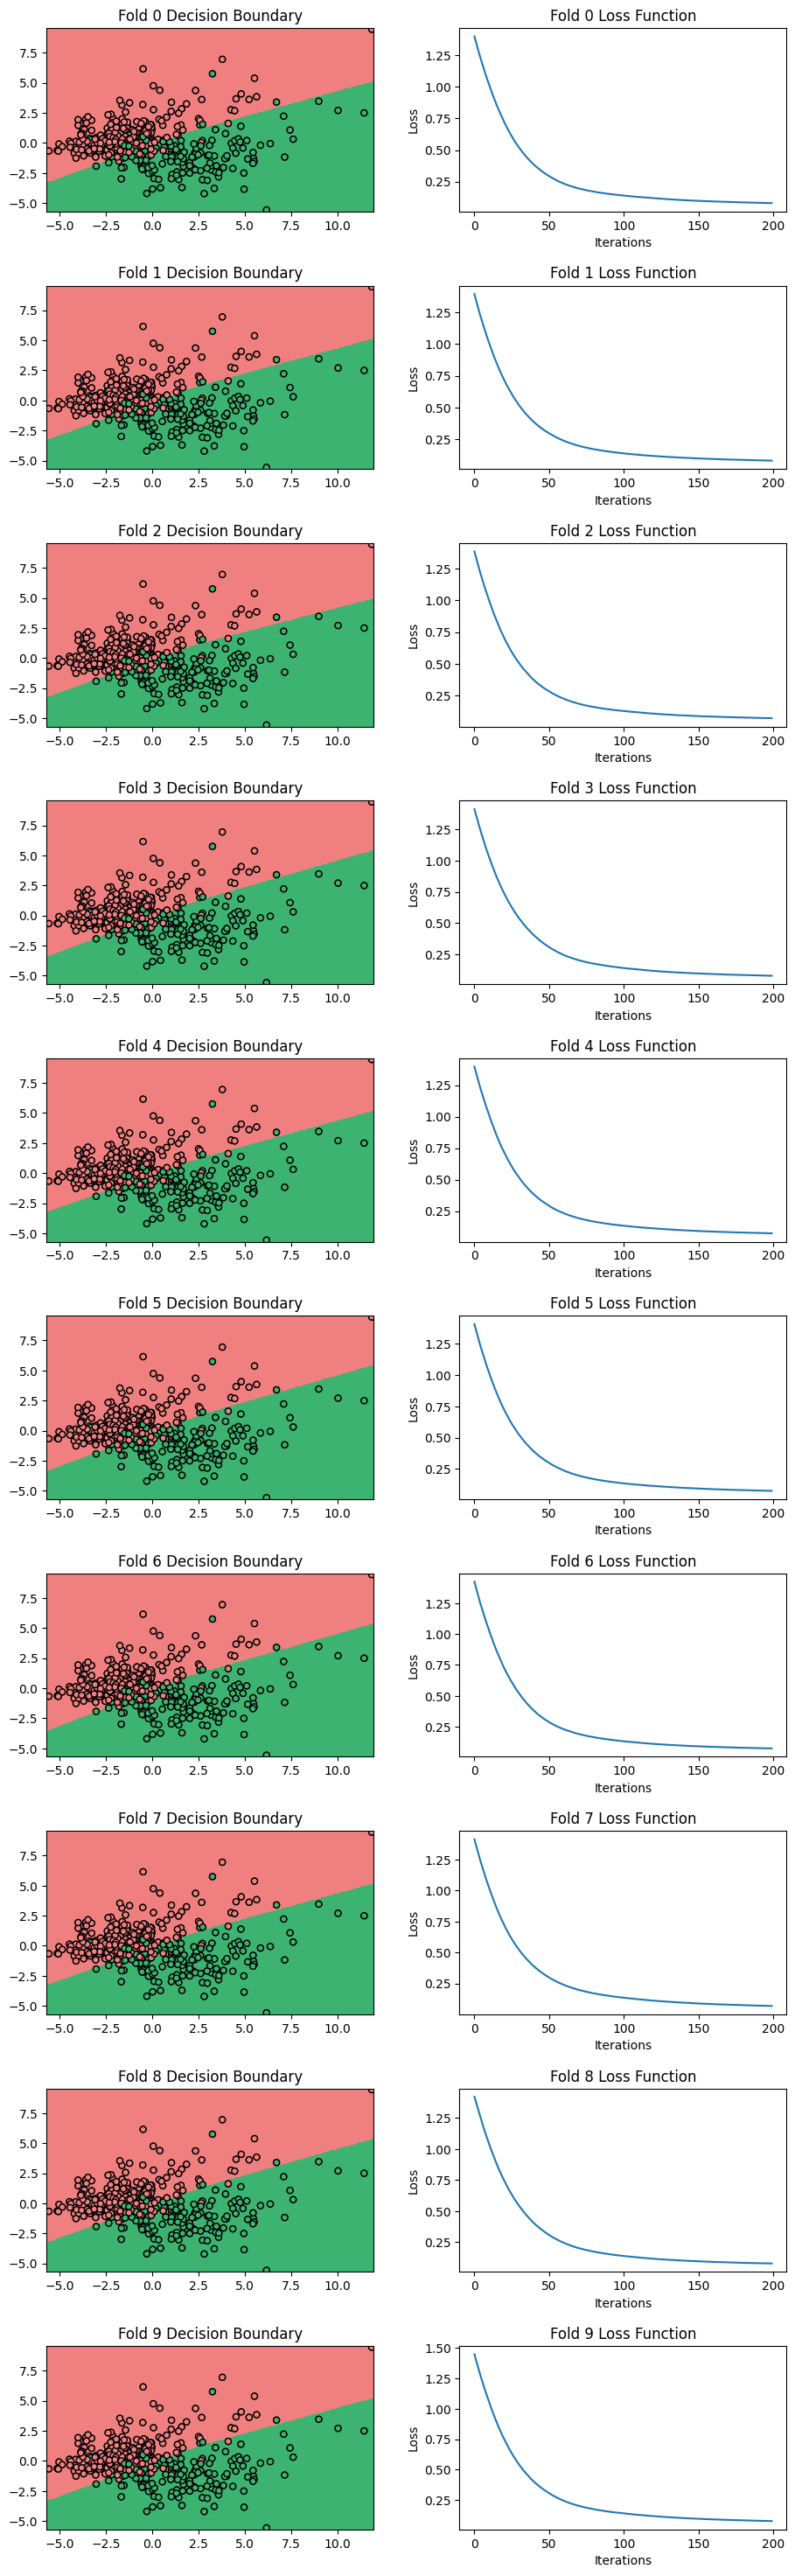

In [ ]:
# Import CV related libraries
from sklearn.model_selection import StratifiedKFold
# Import performance related libraries
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             f1_score, confusion_matrix, RocCurveDisplay)
# Import ML model
from sklearn.neural_network import MLPClassifier

pcs = [0, 1]

metrics_df = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1-Score'],
                          index=[f"Fold {i}" for i in np.arange(0, 10)])

scv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
X, y = bcw_train.drop('target', axis=1), bcw_train['target']

# Set up a 10x2 grid of subplots
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(10,30))  # Adjust size as needed
fig.tight_layout(pad=4.0)  # Padding between plots for better visibility

for i, (train, validation) in enumerate(scv.split(X, y)):
    # Initialize and train MLP
    mlp = MLPClassifier(hidden_layer_sizes=(5,), batch_size=50, learning_rate_init=1e-3,
                        learning_rate='constant', shuffle=True, solver='adam', random_state=42)
    mlp.fit(X.iloc[train], y.iloc[train])
    y_pred = mlp.predict(X.iloc[validation])

    # Plot Decision Boundary on the left column
    xx, yy, zz = decision_boudary(mlp, X.min(axis=0)[pcs], X.max(axis=0)[pcs], X.shape[1], feature_ids=pcs)
    cmap = colors.ListedColormap(['lightcoral', 'mediumseagreen'])
    axes[i, 0].pcolormesh(xx, yy, zz.astype(float), cmap=cmap)
    clrs = [ ('lightcoral', 'mediumseagreen')[int(y_i)] for y_i in y]
    axes[i, 0].scatter(X.values[:, pcs[0]], X.values[:, pcs[1]], ec='k', color=clrs, s=25)
    axes[i, 0].set_title(f'Fold {i} Decision Boundary')

    # Plot Loss curve on the right column
    axes[i, 1].plot(mlp.loss_curve_)
    axes[i, 1].set_title(f'Fold {i} Loss Function')
    axes[i, 1].set_xlabel('Iterations')
    axes[i, 1].set_ylabel('Loss')

    # Store performance metrics
    metrics_df.loc[f'Fold {i}', 'Accuracy'] = accuracy_score(y.iloc[validation], y_pred)
    metrics_df.loc[f'Fold {i}', 'Precision'] = precision_score(y.iloc[validation], y_pred)
    metrics_df.loc[f'Fold {i}', 'Recall'] = recall_score(y.iloc[validation], y_pred)
    metrics_df.loc[f'Fold {i}', 'F1-Score'] = f1_score(y.iloc[validation], y_pred)

# Display the figure
plt.show()


In [ ]:
print(metrics_df.to_latex(index=True,
                  float_format="{:.3f}".format,
))

\begin{tabular}{lllll}
\toprule
{} & Accuracy & Precision & Recall & F1-Score \\
\midrule
Fold 0 &    0.974 &     1.000 &  0.933 &    0.966 \\
Fold 1 &    0.974 &     1.000 &  0.933 &    0.966 \\
Fold 2 &    0.974 &     1.000 &  0.933 &    0.966 \\
Fold 3 &    0.974 &     1.000 &  0.933 &    0.966 \\
Fold 4 &    0.974 &     1.000 &  0.933 &    0.966 \\
Fold 5 &    0.974 &     1.000 &  0.929 &    0.963 \\
Fold 6 &    0.921 &     0.923 &  0.857 &    0.889 \\
Fold 7 &    0.974 &     1.000 &  0.929 &    0.963 \\
Fold 8 &    0.974 &     1.000 &  0.929 &    0.963 \\
Fold 9 &    0.947 &     0.929 &  0.929 &    0.929 \\
\bottomrule
\end{tabular}



# Fine tuning

In [12]:
# Import CV related libraries
from sklearn.model_selection import StratifiedKFold
# Import performance related libraries
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             f1_score, confusion_matrix, RocCurveDisplay)
# Import ML model
from sklearn.neural_network import MLPClassifier

pcs = [0, 1]


scv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
X, y = bcw_train.drop('target', axis=1), bcw_train['target']

# Initialize a dataframe to store ML performance measures
results_df = pd.DataFrame(columns=['Hidden layers', 'Neurons per Layer', 'Accuracy', 'F1-Score', 'CPU Time'])

# Define the different configurations
hidden_layer_configs = [[(5,), (10,), (15,), (20,), (50,), (100,)],
                        [(5, 5), (10, 10), (15, 15), (20, 20), (50, 50), (100, 100)],
                        [(5, 5, 5), (10, 10, 10), (15, 15, 15), (20, 20, 20), (50, 50, 50) , (100, 100, 100)]]
"""
# Initialize the figure
fig, axes = plt.subplots(nrows=18, ncols=2, figsize=(10, 60))
fig.tight_layout(pad=4.0)
"""
row_idx = 0
for layer_configs in hidden_layer_configs:
    for hidden_layer_sizes in layer_configs:
        start_time = time.time()
        # Initialize data containers for combined plots
        combined_loss_curve = []

        # Initialize accuracy and f1 scores measures
        total_accuracy = 0
        total_f1 = 0

        for i, (train, validation) in enumerate(scv.split(X, y)):
            # Initialize and train MLP
            mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, batch_size=50, learning_rate_init=1e-3,
                                learning_rate='constant', shuffle=True, solver='adam', random_state=42)
            mlp.fit(X.iloc[train], y.iloc[train])
            y_pred = mlp.predict(X.iloc[validation])

            accuracy = accuracy_score(y.iloc[validation], y_pred)
            f1 = f1_score(y.iloc[validation], y_pred)

            total_accuracy += accuracy
            total_f1 += f1

            # Combine loss curves
            if i == 0:
                combined_loss_curve = np.array(mlp.loss_curve_)
            else:
                # Ensure the length of loss_curve_ is the same for accumulation
                min_len = min(len(combined_loss_curve), len(mlp.loss_curve_))
                combined_loss_curve[:min_len] += np.array(mlp.loss_curve_[:min_len])

        # Average the combined_loss_curve
        combined_loss_curve /= 10 # 10 folds...

        # Compute average metrics over all folds
        avg_accuracy = total_accuracy / 10
        avg_f1 = total_f1 / 10

        end_time = time.time()  # Record end time
        cpu_time = end_time - start_time  # Calculate elapsed time

        # Update results DataFrame
        results_df.loc[row_idx] = [len(hidden_layer_sizes), hidden_layer_sizes[0], avg_accuracy, avg_f1, cpu_time]
        row_idx += 1
        """
        # Plot Decision Boundary on the left column
        xx, yy, zz = decision_boudary(mlp, X.min(axis=0)[pcs], X.max(axis=0)[pcs], X.shape[1], feature_ids=pcs)
        cmap = colors.ListedColormap(['lightcoral', 'mediumseagreen'])
        axes[row_idx, 0].pcolormesh(xx, yy, zz.astype(float), cmap=cmap)
        clrs = [ ('lightcoral', 'mediumseagreen')[int(y_i)] for y_i in y]
        axes[row_idx, 0].scatter(X.values[:, pcs[0]], X.values[:, pcs[1]], ec='k', color=clrs, s=25)
        axes[row_idx, 0].set_title(f'Neurons: {hidden_layer_sizes} | Decision Boundary')

        # Plot averaged Loss curve on the right column
        axes[row_idx, 1].plot(combined_loss_curve)
        axes[row_idx, 1].set_title(f'Neurons: {hidden_layer_sizes} | Loss Function')
        axes[row_idx, 1].set_xlabel('Iterations')
        axes[row_idx, 1].set_ylabel('Loss')

        row_idx += 1

plt.show()
"""

In [7]:
results_df.iloc[results_df['Accuracy'].idxmax(), :]

TypeError: ignored

In [ ]:
results_df.iloc[results_df['F1-Score'].idxmax(), :]

Hidden layers         2.000000
Neurons per Layer    20.000000
Accuracy              0.984211
F1-Score              0.978289
CPU Time              7.656348
Name: 9, dtype: float64

In [ ]:
print(results_df.iloc[results_df['F1-Score'].idxmax(), :].to_latex(index=True,
                  float_format="{:.3f}".format,
))

\begin{tabular}{lr}
\toprule
{} &      9 \\
\midrule
Hidden layers     &  2.000 \\
Neurons per Layer & 20.000 \\
Accuracy          &  0.984 \\
F1-Score          &  0.978 \\
CPU Time          &  5.868 \\
\bottomrule
\end{tabular}



In [13]:
results_df

,Hidden layers,Neurons per Layer,Accuracy,F1-Score,CPU Time
0,1.0,5.0,0.965857,0.953394,7.129980
1,1.0,10.0,0.973684,0.963738,4.459107
2,1.0,15.0,0.968489,0.957849,7.493644
3,1.0,20.0,0.981579,0.975351,5.915206
4,1.0,50.0,0.981579,0.975351,6.086189
5,1.0,100.0,0.976451,0.967918,6.830850
6,2.0,5.0,0.968489,0.957856,7.980525
7,2.0,10.0,0.968556,0.956789,6.661584
8,2.0,15.0,0.979015,0.971648,6.356595
9,2.0,20.0,0.984211,0.978289,7.523371


In [9]:
def plot_metrics(df, num_hidden_layers):
    # Filter dataframe based on the number of hidden layers
    filtered_df = df[df["Hidden layers"] == num_hidden_layers]

    # Extract values for plotting
    x_values = filtered_df["Neurons per Layer"].values
    acc_values = filtered_df["Accuracy"].values
    f1_values = filtered_df["F1-Score"].values

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x_values, acc_values, marker='o', label="Accuracy", color='blue')
    plt.plot(x_values, f1_values, marker='x', label="F1-Score", color='red')
    plt.xlabel("Number of Neurons per Layer")
    plt.ylabel("Score")
    plt.title(f"Accuracy and F1-Score vs. Neurons per Layer ({num_hidden_layers} Hidden Layer{'s' if num_hidden_layers > 1 else ''})")
    plt.legend()
    plt.grid(True)
    plt.show()

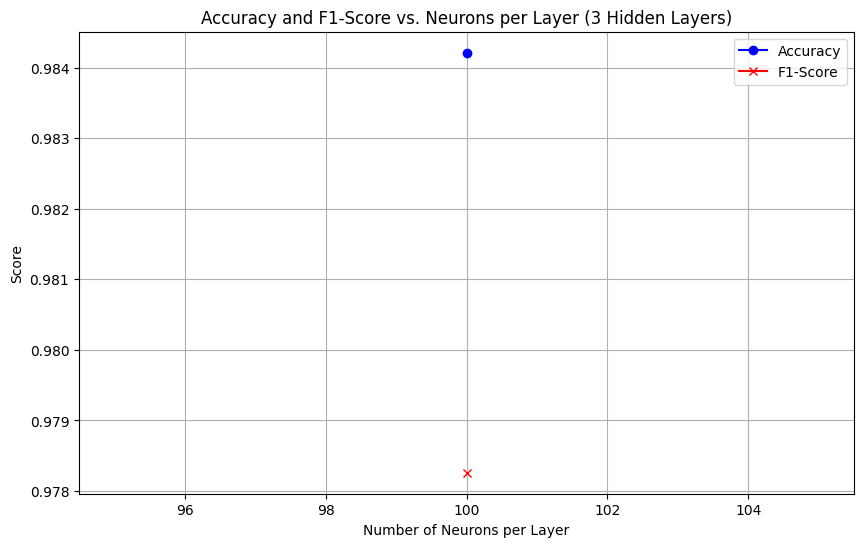

In [10]:
plot_metrics(results_df, 3)

In [17]:
def plot_metrics(df):
    hidden_layers = df["Hidden layers"].unique()
    hidden_layers.sort()
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

    # Plot accuracy for each hidden layer
    for hl in hidden_layers:
        filtered_df = df[df["Hidden layers"] == hl]
        axes[0].plot(filtered_df["Neurons per Layer"], filtered_df["Accuracy"], marker='o', label=f"{int(hl)} Hidden Layers")
    axes[0].set_xlabel("Number of Neurons per Layer")
    axes[0].set_ylabel("Accuracy")
    axes[0].set_title("Accuracy vs. Neurons per Layer")
    axes[0].legend()
    axes[0].grid(True)

    # Plot F1-score for each hidden layer
    for hl in hidden_layers:
        filtered_df = df[df["Hidden layers"] == hl]
        axes[1].plot(filtered_df["Neurons per Layer"], filtered_df["F1-Score"], marker='x', label=f"{int(hl)} Hidden Layers")
    axes[1].set_xlabel("Number of Neurons per Layer")
    axes[1].set_ylabel("F1-Score")
    axes[1].set_title("F1-Score vs. Neurons per Layer")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


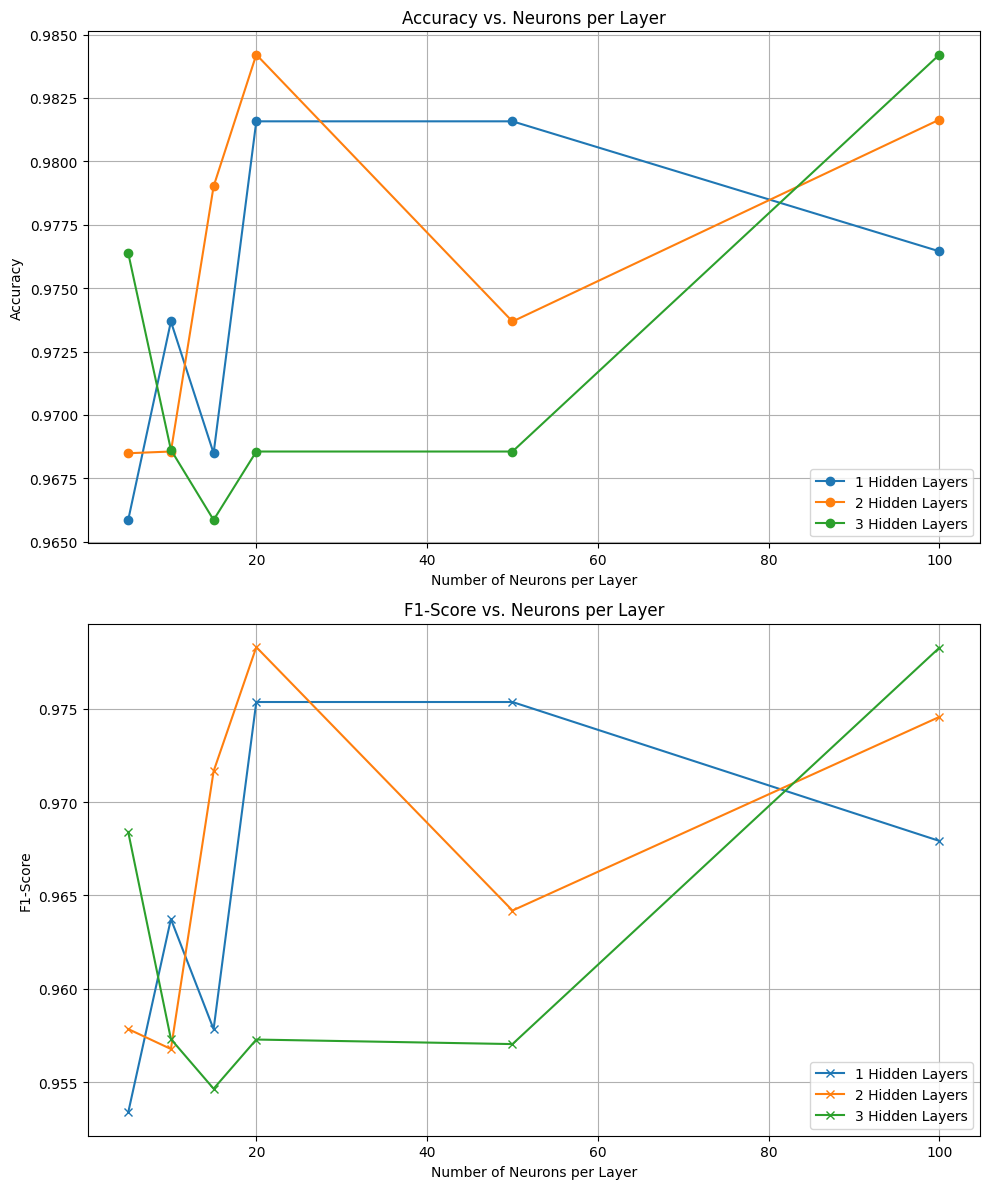

In [18]:
plot_metrics(results_df)

Learning rate

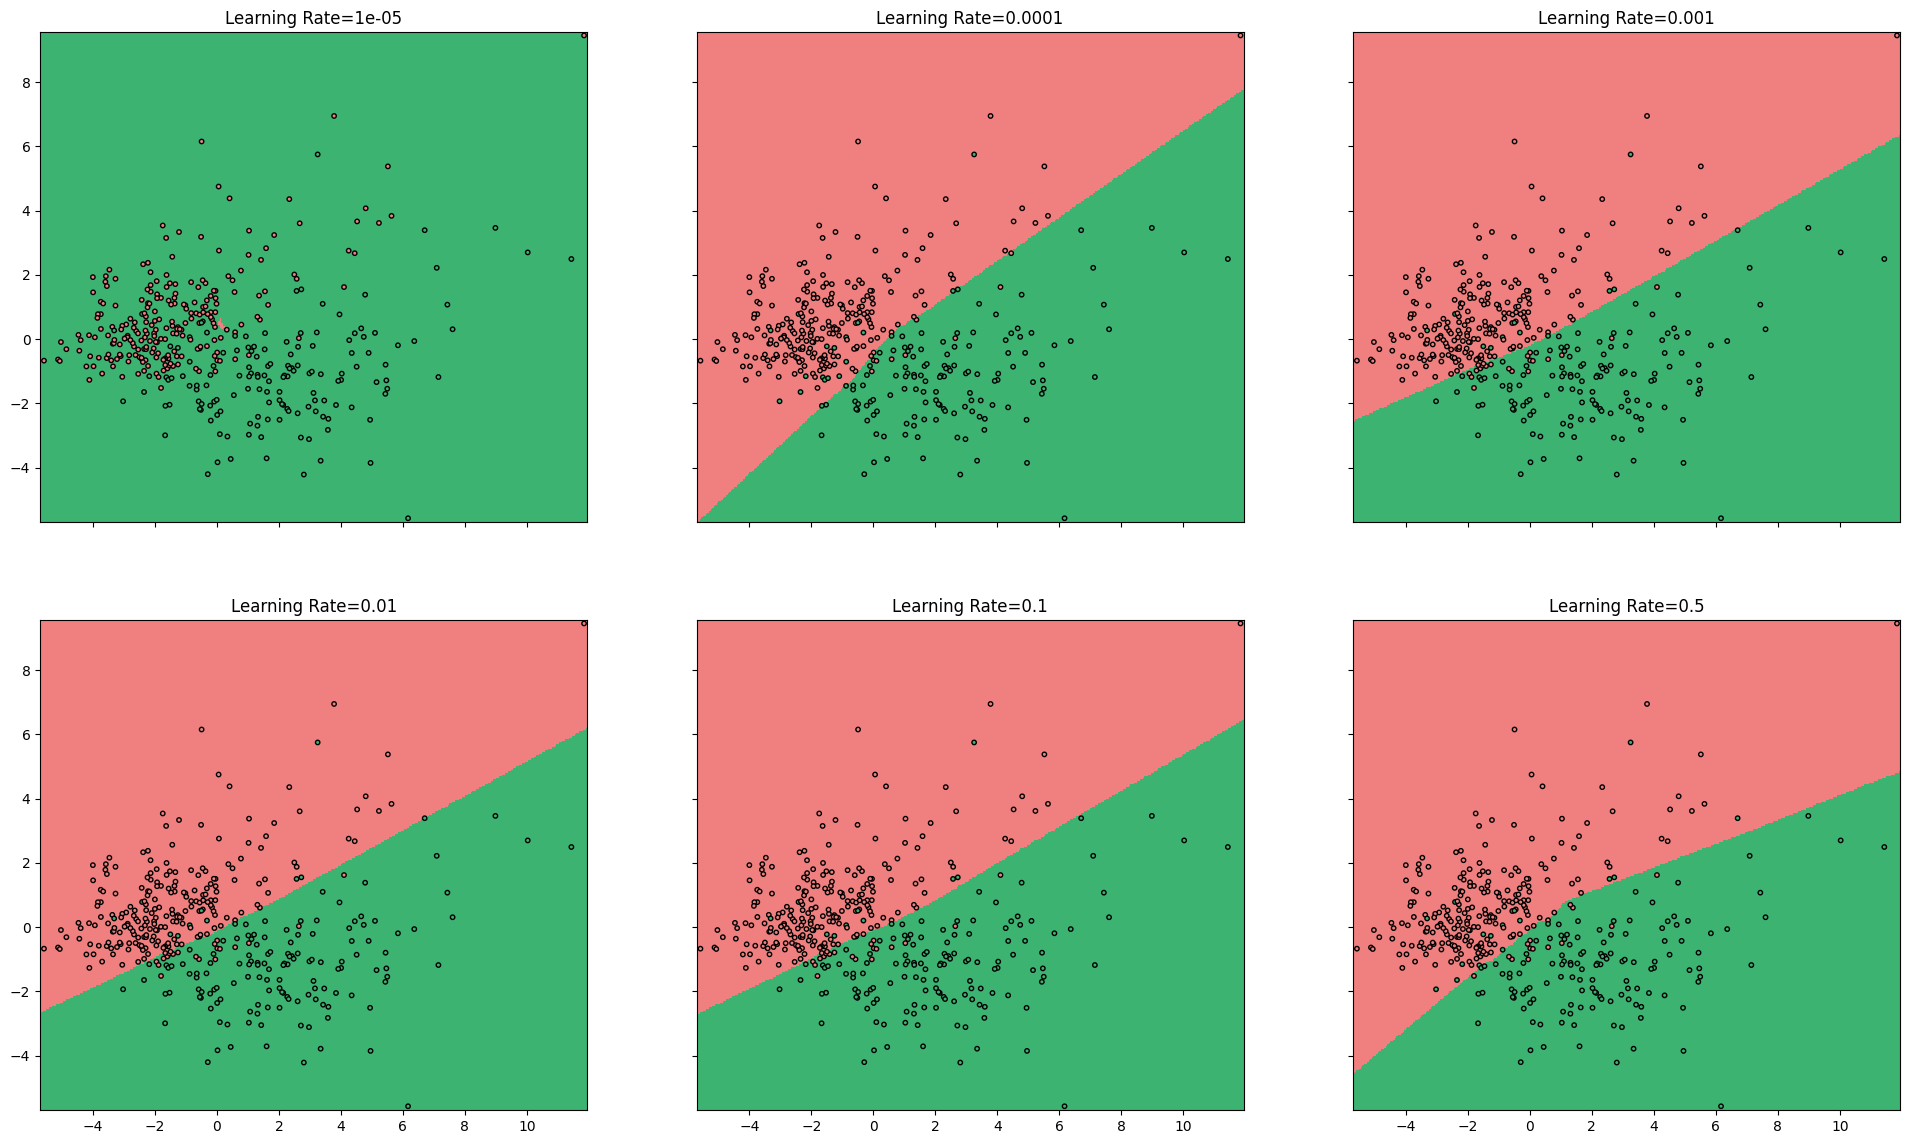

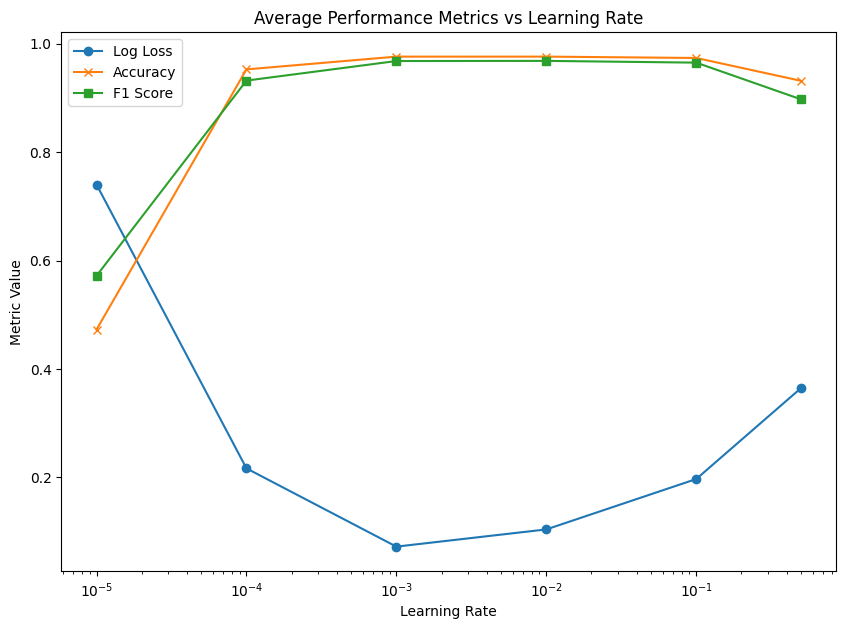

In [ ]:
from sklearn.metrics import log_loss

# Your decision boundary function and other data pre-processing code is assumed to be loaded

lr_values = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 0.5]
scv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
X, y = bcw_train.drop('target', axis=1), bcw_train['target']

f, axes = plt.subplots(2, 3, figsize=(24, 14), sharex=True, sharey=True)

avg_logloss_values = []
avg_accuracy_values = []
avg_f1_values = []

for ax, lr in zip(axes.flatten(), lr_values):
    logloss_values = []
    accuracy_values = []
    f1_values = []

    for i, (train, validation) in enumerate(scv.split(X, y)):
        # Initialize and train MLP
        mlp = MLPClassifier(hidden_layer_sizes=(20, 20), batch_size=50,
                            learning_rate_init=lr, learning_rate='constant',
                            shuffle=True, random_state=0)
        mlp.fit(X.iloc[train], y.iloc[train])
        y_pred_proba = mlp.predict_proba(X.iloc[validation])
        y_pred = mlp.predict(X.iloc[validation])

        logloss_values.append(log_loss(y.iloc[validation], y_pred_proba))
        accuracy_values.append(accuracy_score(y.iloc[validation], y_pred))
        f1_values.append(f1_score(y.iloc[validation], y_pred))

    # Plot decision boundary
    xx, yy, zz = decision_boudary(mlp, X.min(axis=0)[pcs], X.max(axis=0)[pcs], X.shape[1], feature_ids=pcs)
    cmap = colors.ListedColormap(['lightcoral', 'mediumseagreen'])
    ax.pcolormesh(xx, yy, zz.astype(float), cmap=cmap)
    clrs = [('lightcoral', 'mediumseagreen')[int(y_i)] for y_i in y]
    ax.scatter(X.values[:, pcs[0]], X.values[:, pcs[1]], ec='k', color=clrs, s=10)
    ax.set_title(f"Learning Rate={lr}")

    # Calculate the average metrics and append to the respective lists
    avg_logloss_values.append(np.mean(logloss_values))
    avg_accuracy_values.append(np.mean(accuracy_values))
    avg_f1_values.append(np.mean(f1_values))

# Plotting the average metrics
f, ax = plt.subplots(figsize=(10,7))

# Plot average values for each metric
ax.plot(lr_values, avg_logloss_values, label='Log Loss', marker='o')
ax.plot(lr_values, avg_accuracy_values, label='Accuracy', marker='x')
ax.plot(lr_values, avg_f1_values, label='F1 Score', marker='s')

# Set title and labels
ax.set_title('Average Performance Metrics vs Learning Rate')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Metric Value')
ax.set_xscale('log')  # Setting x-axis to log scale for better visualization
ax.legend()

plt.show()


Alpha

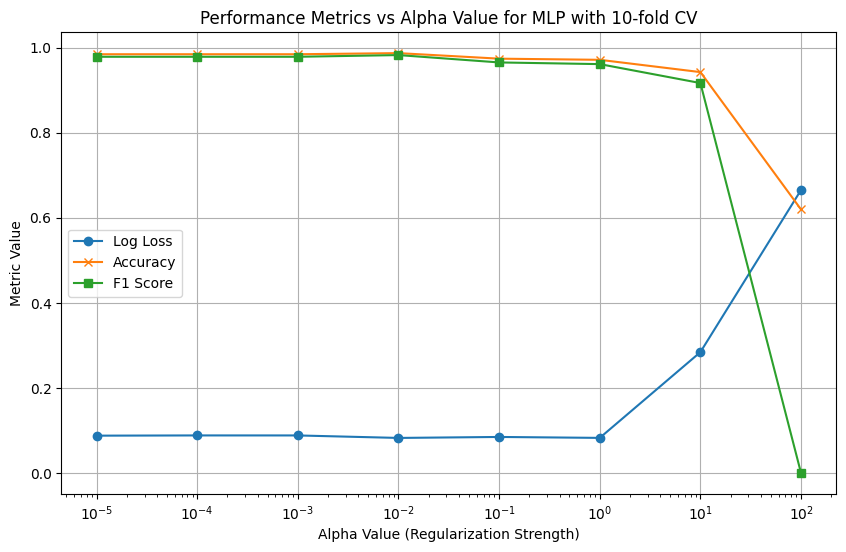

In [ ]:
X, y = bcw_train.drop('target', axis=1), bcw_train['target']

# Different alpha values to try
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

log_losses = []
accuracies = []
f1_scores = []

scv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

for alpha in alphas:

    fold_log_losses = []
    fold_accuracies = []
    fold_f1_scores = []

    for i, (train, validation) in enumerate(scv.split(X, y)):
        X_train, X_val = X.iloc[train], X.iloc[validation]
        y_train, y_val = y.iloc[train], y.iloc[validation]

        mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, batch_size=50, learning_rate_init=1e-3,
                                learning_rate='constant', shuffle=True, solver='adam', alpha=alpha, random_state=42)
        mlp.fit(X_train, y_train)

        # Make predictions
        probabilities = mlp.predict_proba(X_val)
        predictions = mlp.predict(X_val)

        # Calculate metrics
        loss = log_loss(y_val, probabilities)
        acc = accuracy_score(y_val, predictions)
        f1 = f1_score(y_val, predictions)

        # Append to fold lists
        fold_log_losses.append(loss)
        fold_accuracies.append(acc)
        fold_f1_scores.append(f1)

    # Append mean metrics for this alpha value to main lists
    log_losses.append(np.mean(fold_log_losses))
    accuracies.append(np.mean(fold_accuracies))
    f1_scores.append(np.mean(fold_f1_scores))

# Plot
plt.figure(figsize=(10,6))
plt.semilogx(alphas, log_losses, marker='o', label='Log Loss')
plt.semilogx(alphas, accuracies, marker='x', label='Accuracy')
plt.semilogx(alphas, f1_scores, marker='s', label='F1 Score')
plt.xlabel('Alpha Value (Regularization Strength)')
plt.ylabel('Metric Value')
plt.title('Performance Metrics vs Alpha Value for MLP with 10-fold CV')
plt.legend()
plt.grid(True)
plt.show()


# Test

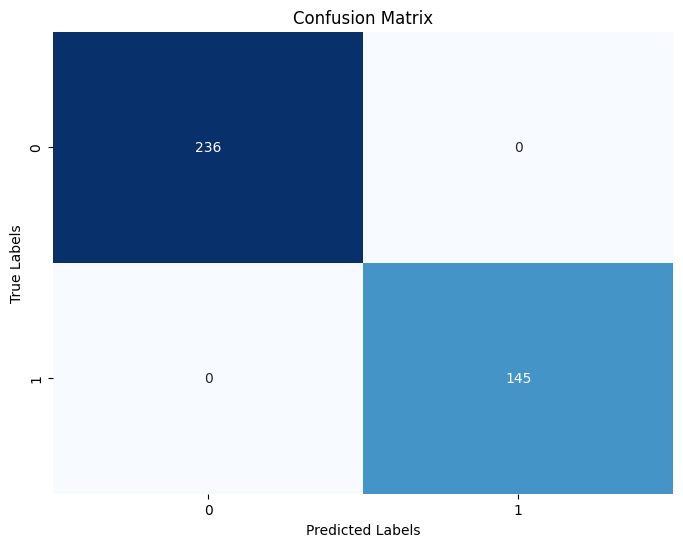

\begin{tabular}{lrrrrl}
\toprule
{} &  Accuracy &  Precision &  Recall &  F1-Score & Model \\
\midrule
0 &     1.000 &      1.000 &   1.000 &     1.000 &   MLP \\
\bottomrule
\end{tabular}



In [ ]:
X_train, y_train = bcw_train.drop('target', axis=1), bcw_train['target']

mlp = MLPClassifier(hidden_layer_sizes=(20, 20), batch_size=50,
                    learning_rate_init=1e-3, learning_rate='constant',
                    shuffle=True, solver='adam', alpha=1e-2, random_state=42)
mlp.fit(X_train, y_train)
X_test, y_test = bcw_test.drop('target', axis=1), bcw_test['target']
y_pred = mlp.predict(X)
final_metrics = pd.DataFrame(data={'Accuracy': accuracy_score(y, y_pred),
                                   'Precision': accuracy_score(y, y_pred),
                                   'Recall': recall_score(y, y_pred),
                                   'F1-Score': f1_score(y, y_pred)}, index=[0])
final_metrics['Model'] = 'MLP'

# Compute the confusion matrix
cm = confusion_matrix(y, y_pred)
# Plot the heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
print(final_metrics.to_latex(index=True,
                  float_format="{:.3f}".format,
))

In [ ]:
model_metrics = pd.concat([model_metrics, final_metrics], ignore_index=True)
model_metrics

,Accuracy,Precision,Recall,F1-Score,Model
0,0.882979,0.882979,0.820896,0.833333,GNB
1,0.936170,0.936170,0.880597,0.907692,KNN
2,0.904000,0.904000,0.881000,0.868000,DTREE
3,0.979000,0.979000,0.985000,0.971000,SVM
4,1.000000,1.000000,1.000000,1.000000,MLP


In [ ]:
# model_metrics.to_csv(os.path.join('/content/drive/MyDrive/Datasets/SI_final_project', 'model_metrics.csv'), index=False)

In [ ]:
model_metrics = pd.read_csv(os.path.join('/content/drive/MyDrive/Datasets/SI_final_project', 'model_metrics.csv'))
model_metrics

,Accuracy,Precision,Recall,F1-Score,Model
0,0.882979,0.882979,0.820896,0.833333,GNB
1,0.936170,0.936170,0.880597,0.907692,KNN
2,0.904000,0.904000,0.881000,0.868000,DTREE
3,0.979000,0.979000,0.985000,0.971000,SVM
4,1.000000,1.000000,1.000000,1.000000,MLP
